# Natural Language Processing (NLP)

**Natural Language Processing (NLP) is a field that combines computer science, artificial intelligence and linguistics to enable computers to understand, process and generate human language in a meaningful way.** With the growing amount of text data from social media, websites and other sources, NLP is becoming a key tool to gain insights and automate tasks like analyzing text or translating languages.

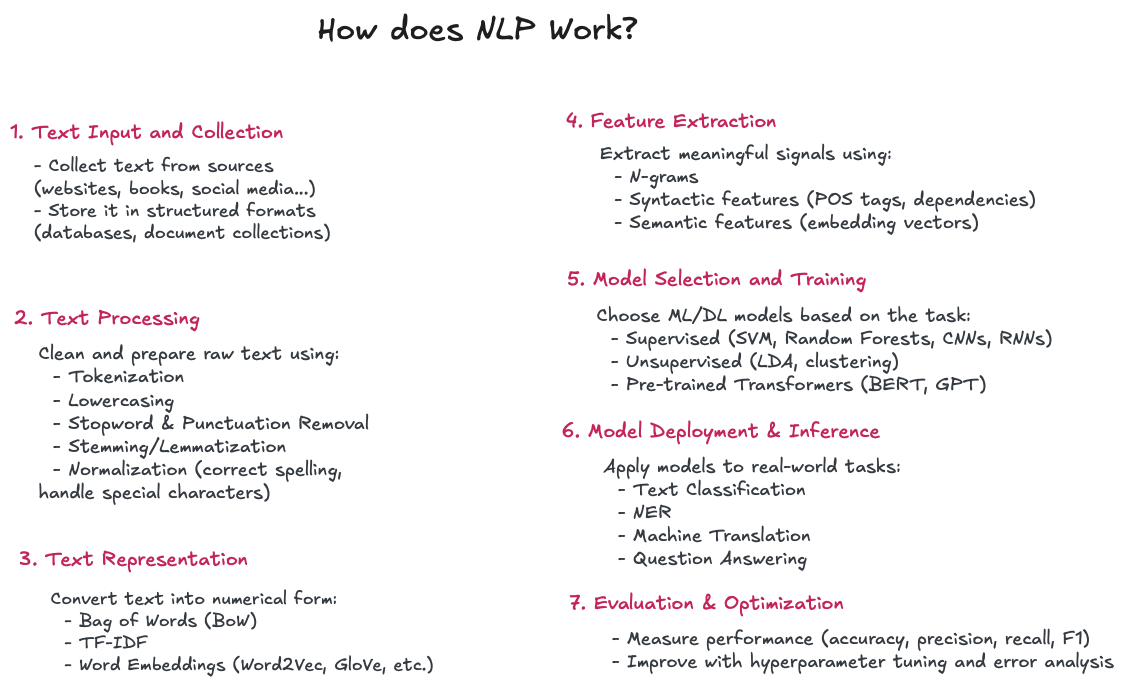

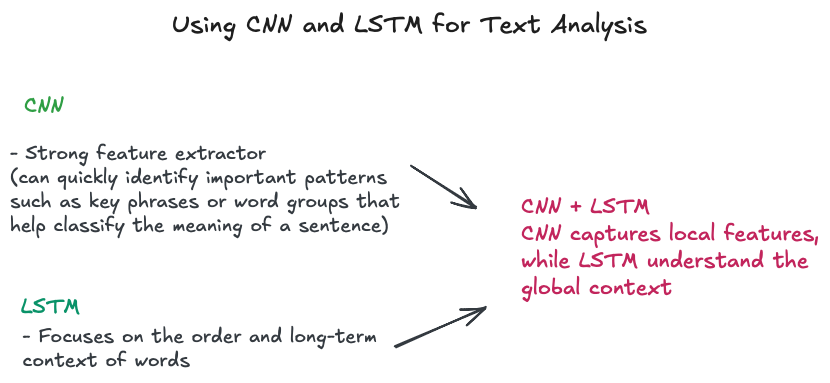

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("emotions-dataset.csv")  #ml
df

,message,emotion
0,i used to be able to hang around talk with the...,anger
1,i get made to feel left out and unimportant in...,sadness
2,i wasnt going to post today as i am feeling qu...,sadness
3,i feel extremely delicate and a bit helpless,love
4,i feel frightened that i might fail to notice ...,fear
...,...,...
11995,i feel useless for wasting k hours k just for ...,sadness
11996,i feel rushed and pulled and rung out and i kn...,anger
11997,i feel absolutely disgusted,anger
11998,i know that we are all sinners and fall short ...,sadness


Check if the dataset is balanced.

<Axes: xlabel='emotion'>

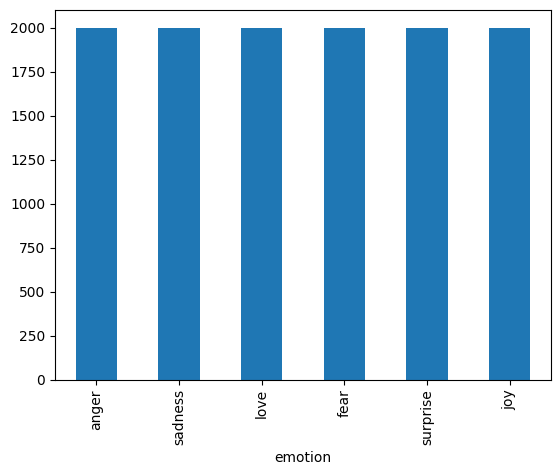

In [3]:
df["emotion"].value_counts().plot.bar()
#Пред да тренираш NLP модел → секогаш провери дали класите се балансирани.i koristi f1 voa noa


Check if there are missing values.

In [4]:
df.isnull().sum()

message    0
emotion    0
dtype: int64

Plot the distribution of words per text.

<Axes: ylabel='Frequency'>

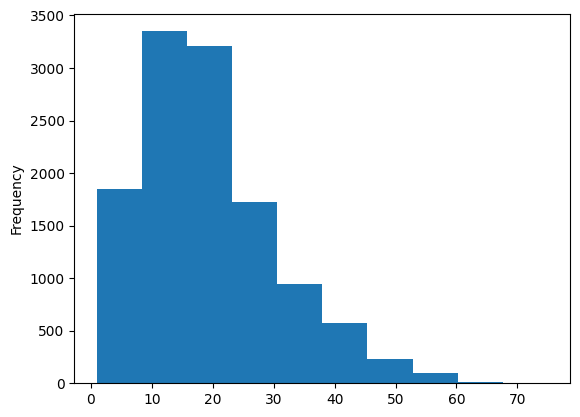

In [5]:
df["message"].str.split(" ").apply(len).plot.hist()  #број на зборови
#→ ја зема колоната со текст(message)
#.str.split(" ")→ го дели текстот на зборови (по празно место)
#.apply(len)→ брои колку зборови има секоја порака




In [ ]:
"""
Most messages are between 10-20 characters/words long
The distribution is right-skewed - there are fewer very long messages
Most data is concentrated in the shorter length range
"""

<Axes: >

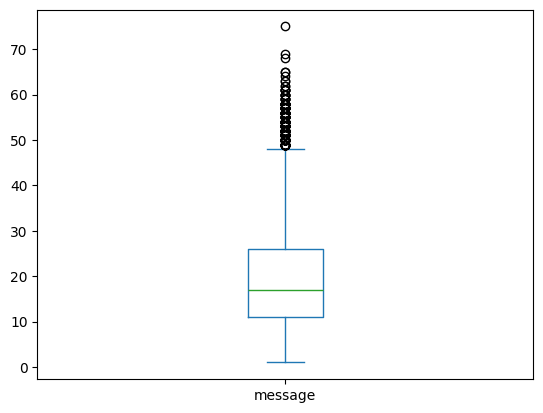

In [6]:
df["message"].str.split().apply(len).plot.box()

In [ ]:
"""
Median: Around 15-20 (the line inside the box)
Interquartile Range (IQR): The box spans roughly from 10 to 25
Many outliers: All those circles above 40 represent unusually long messages
The presence of many outliers confirms the right skew seen in the histogra
"""

In [7]:
df = df[df["message"].str.split().apply(len) < 45].copy(deep=True)
df

#voa e drop fakticki na poraki so povece od 45zbora,→ задржува само пораки со помалку од 45 зборови
#df = df[ ... ].copy(deep=True)→ брише (drop) сите пораки со ≥45 зборови→ прави безбедна копија
#ok e da se naprave voa bidejki: Очигледни outliers :95% од пораките < 40 зборови a i balansirano e zatoa ako ne bese bal togas voa ne 


,message,emotion
0,i used to be able to hang around talk with the...,anger
1,i get made to feel left out and unimportant in...,sadness
3,i feel extremely delicate and a bit helpless,love
4,i feel frightened that i might fail to notice ...,fear
5,i feel stubborn because i just want my seattle...,anger
...,...,...
11995,i feel useless for wasting k hours k just for ...,sadness
11996,i feel rushed and pulled and rung out and i kn...,anger
11997,i feel absolutely disgusted,anger
11998,i know that we are all sinners and fall short ...,sadness


<Axes: ylabel='Frequency'>

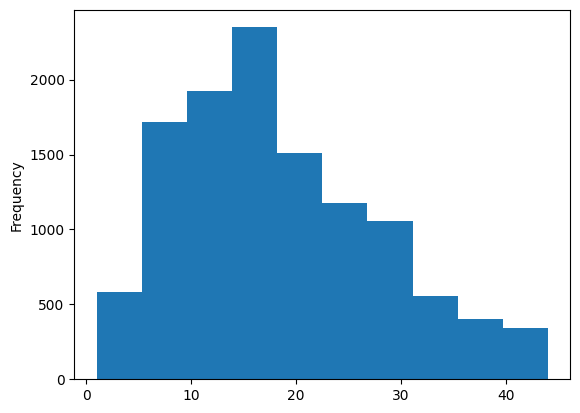

In [8]:
df["message"].str.split().apply(len).plot.hist()

<Axes: >

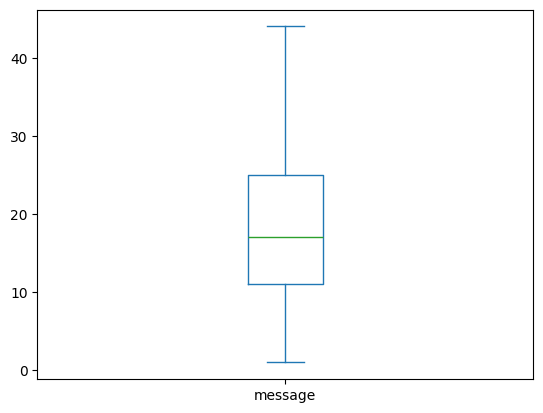

In [9]:
df["message"].str.split().apply(len).plot.box()

In [ ]:
#sega ide pretprocesiranje:

In [10]:
X, y, num_classes = df["message"], df["emotion"].astype("category").cat.codes, len(df["emotion"].unique())

"""
X = df["message"] e features/tekstovite
df["emotion"].astype("category") ➡️ ја претвора колоната emotion во категориска
.cat.codes➡️ ги мапира емоциите во бројки pr happy ->0 sad->1 anger->2
y = ...➡️ labels за класификација
num_classes = len(df["emotion"].unique())➡️ колку класи има моделот(важно за CrossEntropyLoss, softmax, output layer)


y = df["emotion"].astype("category").cat.codes
се прави пред train/test split, тогаш е ОК.

"""

In [11]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42
)

In [12]:
def build_vocab(texts, max_vocab_size):
    counter = Counter()  #➡️ брои колку пати се појавува секој збор

    for sentence in texts:            #➡️ ги собира фреквенциите на сите зборови во dataset-от
        counter.update(sentence.split())

    # Special tokens
    vocab = {
        "<PAD>": 0,           #padding
        "<OOV>": 1              #→  (unseen word)
    }

    for idx, (word, _) in enumerate(             #➡️ ги зема најчестите зборови➡️ -2 затоа што:2 места се веќе зафатени (<PAD>, <OOV>)
        counter.most_common(max_vocab_size - 2), start=2              #start=2 oti реалните зборови почнуваат од индекс 2 
    ):
        vocab[word] = idx     #➡️ word → integer mapping

    return vocab

#➡️ само кодира текст
    #Оваа функција е чисто NLP preprocessing

In [13]:
max_vocab_size = 10000
vocab = build_vocab(train_X.values, max_vocab_size)

"""
➡️ поставуваш горна граница за бројот на зборови
➡️ спречуваш преголем vocab (memory + overfitting)

➡️ го градиш vocabulary САМО од train податоците

"""

In [14]:
def texts_to_sequences(texts, vocab):     
    sequences = []

    for sentence in texts:  #➡️ оди низ сите пораки
        seq = [
            vocab.get(word, vocab["<OOV>"]) #➡️ ако зборот постои → негов индекс➡️ ако НЕ постои → <OOV> (1)
            for word in sentence.split()
        ]
        sequences.append(seq)    #➡️ секоја порака станува листа од бројки

    return sequence


    """
👉 Го претвора текстот во листа од индекси според vocab.
"I am happy" -> 
vocab = {
  "<PAD>": 0,
  "<OOV>": 1,
  "i": 2,
  "am": 3,
  "happy": 4
}          ->[2, 3, 4]
„Текстовите се енкодирани во нумерички секвенци врз основа на претходно изграден речник, 
при што непознатите зборови се мапираат во OOV токен.“

    """

In [15]:
train_X = texts_to_sequences(train_X.values, vocab)
val_X   = texts_to_sequences(val_X.values, vocab)
test_X  = texts_to_sequences(test_X.values, vocab)

In [16]:
def pad(sequences, pad_value=0):
    return pad_sequence(
        [torch.tensor(seq, dtype=torch.long) for seq in sequences],
        batch_first=True,
        padding_value=pad_value
    )


"""
#само подготовка за модел.
Што прави pad?

👉 Ги прави сите секвенци иста должина
👉 Кратките → се дополнуваат со <PAD>
👉 Долгите → НЕ се сечат (важно!)

Што ова НЕ прави ❌
❌ не брише реченици
❌ не ограничува должина
❌ не решава дисбаланс
❌ не менува labels
Само форма.

Затоа што тензорите во batch мора да имаат иста форма.
Ова правило важи за сите neural network модели, не само за CNN.
Каде е ЗАДОЛЖИТЕЛНО?
✔️ CNN за текст
✔️ Fully Connected (MLP)
✔️ Transformers (BERT-style)
✔️ RNN / LSTM / GRU

Каде НЕ се користи вака?
❌ Classical ML (TF-IDF + SVM, NB)
"""

In [17]:
train_X = pad(train_X, pad_value=0)
val_X   = pad(val_X,pad_value=0)
test_X  = pad(test_X, pad_value=0)

In [18]:
train_y = torch.tensor(train_y.values, dtype=torch.long)
val_y   = torch.tensor(val_y.values, dtype=torch.long)
test_y  = torch.tensor(test_y.values, dtype=torch.long)
#Ова е точно и задолжително за PyTorch.

"""
Зошто dtype=torch.long?Затоа што:
nn.CrossEntropyLoss
nn.NLLLoss
🔹 CrossEntropyLoss → МОРА .long

1️⃣ BCELoss / BCEWithLogitsLoss👉 НЕ користи .long i 2️⃣ MSELoss (регресија)
y = torch.tensor(y, dtype=torch.float)
criterion = nn.BCEWithLogitsLoss()


Честа грешка (добро што ја немаш)❌ one-hot encoding + CrossEntropyLoss

| Loss функција       | Тип на y      |
| ------------------- | ------------- |
| `CrossEntropyLoss`  | `torch.long`  |
| `NLLLoss`           | `torch.long`  |
| `BCELoss`           | `torch.float` |
| `BCEWithLogitsLoss` | `torch.float` |
| `MSELoss`           | `torch.float` |

"""

In [19]:
class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size, 128, padding_idx=0
        )

        self.conv1 = nn.Conv1d(128, 32, kernel_size=4, padding=2)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=4, padding=2)
        self.pool2 = nn.MaxPool1d(2)

        self.lstm1 = nn.LSTM(64, 128, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True, dropout=0.1)

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)          # (batch, seq, 128)
        x = x.permute(0, 2, 1)         # (batch, 128, seq)

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = x.permute(0, 2, 1)         # (batch, seq, features)

        x, _ = self.lstm1(x)
        _, (h, _) = self.lstm2(x)

        return self.fc(h[-1]) #hidden state се користи за класификација

In [ ]:
"""
SAMO LSTM:

class LSTM_Classifier(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, 128, padding_idx=0)
        self.lstm = nn.LSTM(128, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)      # (batch, seq, 128)
        _, (h, _) = self.lstm(x)   # h: (1, batch, 128)

        return self.fc(h[-1])      # ✔ last hidden state


CNN:

class CNN_Text(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, 128, padding_idx=0)

        self.conv = nn.Conv1d(128, 128, kernel_size=5)
        self.pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)      # (batch, seq, 128)
        x = x.permute(0, 2, 1)     # (batch, 128, seq)

        x = F.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)  # (batch, 128)

        return self.fc(x)


"""

In [20]:
device = (
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

model = CNN_LSTM(
    vocab_size=len(vocab),
    num_classes=num_classes

).to(device)

criterion = nn.CrossEntropyLoss()          #multiclass classification,nema softmax u voa
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Но ова нема врска со дисбаланс — туку со број на класи.
#Кога НЕ се користи CrossEntropyLoss?❌ ако е binary classification➡️ тогаш е подобро:nn.BCEWithLogitsLoss()
"""
| Ситуација                 | Loss                   |
| ------------------------- | ---------------------- |
| Multiclass (балансиран)   | CrossEntropy           |
| Multiclass (небалансиран) | CrossEntropy + weights |
| Binary                    | BCEWithLogits          |

"""

/Users/marijastojcheva/Downloads/i2ds/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/Users/marijastojcheva/Downloads/i2ds/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [21]:
#ДА — ова е потребно за CNN + LSTM модел
#👉 ДА. ОВОЈ LOOP Е ИСТ ЗА CNN, LSTM и CNN+LSTM.


"""
| Модел             | Дали треба ова     |
| ----------------- | ------------------ |
| CNN (text)        | ✅                  |
| LSTM / GRU        | ✅                  |
| CNN + LSTM        | ✅                  |
| Transformer       | ❌ (друг tokenizer) |
| TF-IDF + Logistic | ❌                  |
| Bag of Words      | ❌                  |

"""
train_losses = []
val_losses = []

epochs = 12
batch_size = 64

for epoch in range(epochs):

    # ---------- TRAIN ----------
    model.train()
    running_train_loss = 0.0

    for i in range(0, len(train_X), batch_size):
        X_batch = train_X[i:i+batch_size].to(device)
        y_batch = train_y[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / (len(train_X) // batch_size)
    train_losses.append(avg_train_loss)

    # ---------- VALIDATION ----------
    model.eval()
    running_val_loss = 0.0
    correct = 0

    with torch.no_grad():
        X_val = val_X.to(device)
        y_val = val_y.to(device)

        outputs = model(X_val)
        val_loss = criterion(outputs, y_val)
        running_val_loss += val_loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct = (preds == y_val).sum().item()

    avg_val_loss = running_val_loss
    val_losses.append(avg_val_loss)

    val_acc = correct / len(y_val)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train loss: {avg_train_loss:.4f} | "
        f"Val loss: {avg_val_loss:.4f} | "
        f"Val acc: {val_acc:.4f}"
    )


Epoch 1/12 | Train loss: 1.8053 | Val loss: 1.7685 | Val acc: 0.2062
Epoch 2/12 | Train loss: 1.6541 | Val loss: 1.5337 | Val acc: 0.3285
Epoch 3/12 | Train loss: 1.3048 | Val loss: 1.3640 | Val acc: 0.4017
Epoch 4/12 | Train loss: 1.0450 | Val loss: 1.2649 | Val acc: 0.5057
Epoch 5/12 | Train loss: 0.8505 | Val loss: 1.1332 | Val acc: 0.5934
Epoch 6/12 | Train loss: 0.6563 | Val loss: 1.0721 | Val acc: 0.6554
Epoch 7/12 | Train loss: 0.5188 | Val loss: 1.0723 | Val acc: 0.6710
Epoch 8/12 | Train loss: 0.4504 | Val loss: 0.9797 | Val acc: 0.6947
Epoch 9/12 | Train loss: 0.4088 | Val loss: 0.9537 | Val acc: 0.7006
Epoch 10/12 | Train loss: 0.3049 | Val loss: 0.9856 | Val acc: 0.7151
Epoch 11/12 | Train loss: 0.2759 | Val loss: 1.0406 | Val acc: 0.7178
Epoch 12/12 | Train loss: 0.2660 | Val loss: 0.9905 | Val acc: 0.7329


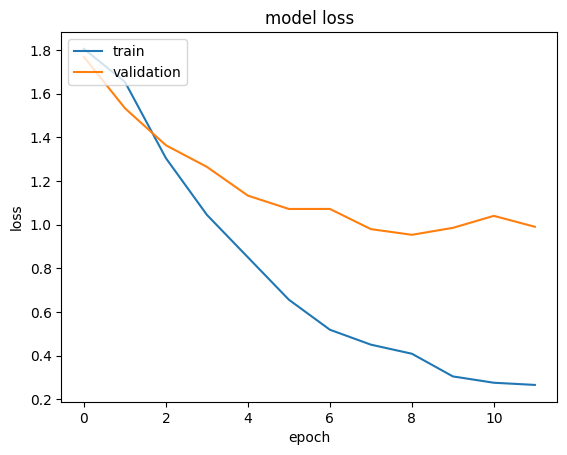

In [22]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

"""
❌ НЕ треба да се поклопуваат
✔️ Треба да бидат блиску и стабилни
"""

In [23]:
model.eval()

with torch.no_grad():
    X_test = test_X.to(device)
    y_test = test_y.to(device)

    outputs = model(X_test)
    preds = torch.argmax(outputs, dim=1)
    test_acc = (preds == y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc:.4f}")
#Кратко: ДА — ИСТО Е и за CNN, и за LSTM, и за CNN+LSTM.

Test accuracy: 0.7196


In [24]:
print(classification_report(y_test.cpu().numpy(), preds.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.69      0.56      0.62       393
           1       0.86      0.67      0.76       384
           2       0.56      0.66      0.61       393
           3       0.86      0.78      0.82       396
           4       0.54      0.73      0.62       343
           5       0.89      0.90      0.90       413

    accuracy                           0.72      2322
   macro avg       0.74      0.72      0.72      2322
weighted avg       0.74      0.72      0.72      2322



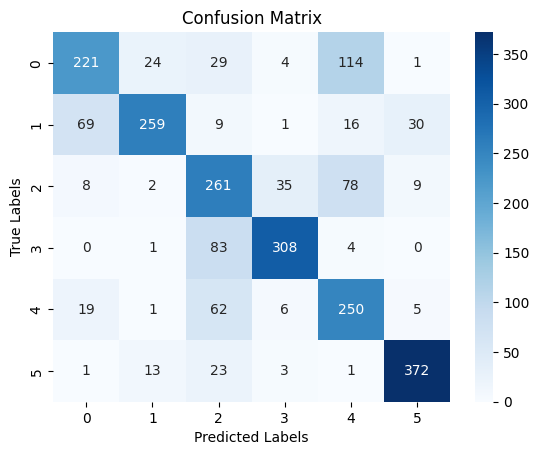

In [25]:
cm = confusion_matrix(
    y_test.cpu().numpy(),
    preds.cpu().numpy()
)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
"""
Cell [0, 0] = 221
True emotion was 0, model predicted 0 ✓
Correct prediction!
---------------------------------
Cell [0, 4] = 114

True emotion was 0, but model predicted 4 ✗
Mistake: confused emotion 0 with emotion 4
--------------------------------------
Cell [1, 5] = 30

True emotion was 1, but model predicted 5 ✗
Mistake: confused emotion 1 with emotion 5
-----------------------------------
The Diagonal = Success
The dark blue diagonal cells are correct predictions. The darker and larger these numbers, the better!
Off-Diagonal = Errors
Any number not on the diagonal is a mistake. The lighter the color and smaller the number, the better.

"""